
# In this notebook I do some data wrangling and cleaning


In [ ]:

import pandas as pd
from datetime import datetime
from PIL import Image
import requests
from io import BytesIO
from ast import literal_eval
import plotly.express as px
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
#from langdetect import detect
#from langdetect import DetectorFactory
#DetectorFactory.seed = 0
from google.colab import files




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
listings = pd.read_csv("/content/drive/My Drive/airbnb/listings_zip.csv",dtype={"zipcode":"string"})
reviews_df = pd.read_csv("/content/drive/My Drive/airbnb/reviews.csv")

In [ ]:
#check data rows and columns
listings.shape

(46527, 72)

In [ ]:
listings

,id,listing_url,scrape_id,name,description,neighborhood_overview,picture_url,host_id,host_url,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,zipcode
0,2595,https://www.airbnb.com/rooms/2595,20200815122933,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,61%,26%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,NaN,1 bath,NaN,1.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$175.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,NaN,t,30,60,90,365,48,2,0,2009-11-21,2019-11-04,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,f,2,2,0,0,0.37,10018
1,3831,https://www.airbnb.com/rooms/3831,20200815122933,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,within a few hours,90%,96%,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"Brooklyn, New York, United States",Clinton Hill,Brooklyn,40.68514,-73.95976,Entire guest suite,Entire home/apt,3,NaN,1 bath,1.0,3.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$75.00,1,730,1.0,1.0,1125.0,1125.0,1.0,1125.0,NaN,t,13,21,40,265,340,64,6,2014-09-30,2020-08-01,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NaN,f,1,1,0,0,4.75,11238
2,5121,https://www.airbnb.com/rooms/5121,20200815122933,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",NaN,NaN,67%,f,https://a0.muscache.com/im/pictures/user/72a61...,https://a0.muscache.com/im/pictures/user/72a61...,Bedford-Stuyvesant,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,NaN,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room in apartment,Private room,2,NaN,NaN,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Heati...",$60.00,29,730,29.0,29.0,730.0,730.0,29.0,730.0,NaN,t,30,60,90,365,50,1,0,2009-05-28,2019-12-02,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NaN,f,1,0,1,0,0.37,11216
3,5136,https://www.airbnb.com/rooms/5136,2

Lets View which columns have a lot of NA values 

In [ ]:
pd.set_option('display.max_rows', None)


In [ ]:
listings.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
name                                               18
description                                      1331
                                                ...  
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               10711
zipcode                                             0
Length: 72, dtype: int64

**Removal of un-necessary data from first glance**

Scraped Id will not provide us with any useful information so it will be dropped ,

All picture url columns will be removed since we will not be doing image processing so Columns: picture_url, host_url , host_thumbnail_url, and host_picture_url.

For location we will remove host_neighborhood and neighborhood columns  there neighborhoud_group_cleansed and neighborhoud_cleansed columns have the same info with no NA values.

The column Calender updated column will be remove since it contains only NAN values. The license columns column is filled with NA only as well so that will be dropped.

In [ ]:
listings = listings.drop(['scrape_id','host_id','listing_url','picture_url','host_url','host_thumbnail_url','host_picture_url','host_neighbourhood','neighbourhood','calendar_updated','license'],axis=1)

Latitude and Longitude will be dropped since we already have zipcode which should give us better results.

There are minimuum_minimum_nighsts and maximum_maximum_nights which are really the same as maximum nights and minimum nights so those will be dropped 

In [ ]:
listings.drop(['latitude','longitude','minimum_minimum_nights','minimum_maximum_nights','maximum_minimum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','host_location'],axis=1, inplace=True)

Lastly I will remove most text columns since it will be hard to quanitify. I will keep description so I can test if the length of a description can affect the asking price

In [ ]:
listings.drop(['neighborhood_overview','name','host_about'],axis=1, inplace=True)

In [ ]:
pd.set_option('display.max_rows', 10)

**Converting textfields to quantive data**

I am curious to see if the length of desription can affect price

In [ ]:
# getting the # of words in each disrciption by matching a regex 
listings.description = listings['description'].str.count(r'\b(?!\b(b|br)\b)\w+\b')

Here I am replacing description , neighborhood_overview ,name , hoat_about with number of words in contains using Regex

Fill any empty descriptions with 0

In [ ]:
# fill any descirpotions with no texts with 0
listings.description = listings['description'].fillna(0)

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
listings.isna().sum()

id                                                  0
description                                         0
host_since                                         35
host_response_time                              24901
host_response_rate                              24901
host_acceptance_rate                            16286
host_is_superhost                                  35
host_listings_count                                35
host_total_listings_count                          35
host_verifications                                  0
host_has_profile_pic                               35
host_identity_verified                             35
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                                       37210
bathrooms_text              

I want to convert host_since date to # of days a host has been on airbnb since the data was scraped 

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
listings.host_since

0        2008-09-09
1        2008-12-07
2        2009-02-03
3        2009-02-03
4        2009-03-03
            ...    
46522    2014-03-09
46523    2019-08-11
46524    2020-08-14
46525    2012-11-02
46526    2015-11-03
Name: host_since, Length: 46527, dtype: object

In [ ]:
# convert to a different format
listings.host_since = pd.to_datetime(listings.host_since)

In [ ]:
# we want to get difference of the time the data was scrappved and host since data
listings['host_since'] = (datetime(2020,8,16)- listings.host_since).astype('timedelta64[D]')

We can remove the 35 nan rows but we can also fill with median 

In [ ]:
print("Median of days active: ",listings['host_since'].median())
print("Mean of days active: ",listings['host_since'].mean())

listings['host_since'].fillna(listings.host_since.median(), inplace = True)

Median of days active:  1868.0
Mean of days active:  1835.00658177751


In [ ]:
listings.isna().sum()


id                                                  0
description                                         0
host_since                                          0
host_response_time                              24901
host_response_rate                              24901
                                                ...  
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               10711
zipcode                                             0
Length: 49, dtype: int64

This is going to check whether booolean and categorical features have sufficent instances to include.(From Laura Lewis)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d2abc07f0>,
      dtype=object)

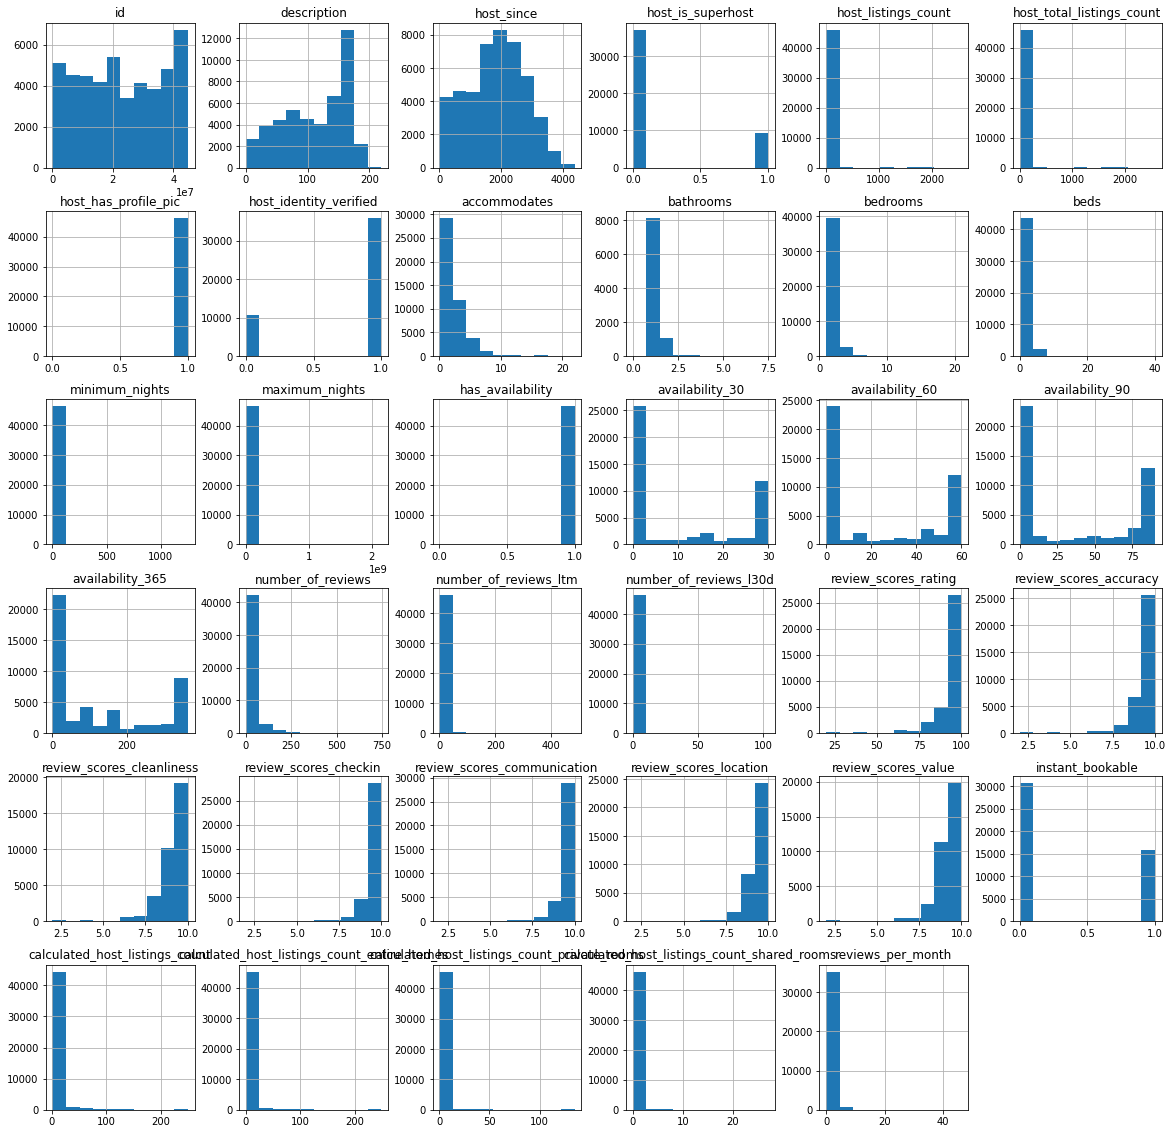

In [ ]:
# this replaces all true and false values with 0 or 1 
listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
listings.hist(figsize=(20,20))

From the data I see that number_of_reviewsitm , and number_of_reviews_l30d is ver similiar to number_of_reviews so those are going to drop.

I also dont see how the different calculated_host_listings_count_sharedroom/private room will be benefical to the dataset. While there are slight differences the only reason I want to include total listings of host is to see if that experience makes that person more money but the room type is information we dont need. So those columns will be dropped as well

host_listings_count is the same as host_listings_count_total so that will be dropped.

In [ ]:
listings.drop(['number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count_entire_homes','calculated_host_listings_count_shared_rooms','calculated_host_listings_count_private_rooms','calculated_host_listings_count','host_listings_count'],axis=1,inplace=True)

Lastly I will remove availibility_60/90/365 since in nyc you can only rent out legally for 30 days. It also seems that the availabilty column is always true so these columns will be removed (Laura)

In [ ]:
listings.drop(['has_availability','availability_60','availability_90','availability_365'],axis=1,inplace=True)

Time to clean up individual Columns 


Right now we will properly label host_respone_time and then properly bin/label host_resposne_rate/host_acceptance_rate

In [ ]:
listings['host_response_time'].fillna("unknown", inplace=True) 

In [ ]:
listings['host_response_time']

0              within a day
1        within a few hours
2                   unknown
3        within a few hours
4        within a few hours
                ...        
46522               unknown
46523               unknown
46524               unknown
46525               unknown
46526               unknown
Name: host_response_time, Length: 46527, dtype: object

Since a good amount of values make up the columns it will be its own separte category and other values will be binned

In [ ]:
print(listings.host_acceptance_rate.isna().sum())
print(listings.host_response_rate.isna().sum())

16286
24901


In [ ]:
# Removing the % sign from the host_response_rate string and converting to an integer
listings.host_response_rate = listings.host_response_rate.str[:-1].astype('float64')
listings.host_acceptance_rate = listings.host_acceptance_rate.str[:-1].astype('float64')

In [ ]:
# Bin into four categories
listings.host_response_rate = pd.cut(listings.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
listings.host_acceptance_rate = pd.cut(listings.host_acceptance_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
listings.host_response_rate = listings.host_response_rate.astype('str')
listings.host_acceptance_rate = listings.host_acceptance_rate.astype('str')


# Replace nulls with 'unknown'
listings.host_response_rate.replace('nan', 'unknown', inplace=True)
listings.host_acceptance_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_response_rate.value_counts()

unknown    24901
100%       13763
50-89%      3630
0-49%       2212
90-99%      2021
Name: host_response_rate, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
listings.isna().sum()

id                                  0
description                         0
host_since                          0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                  35
host_total_listings_count          35
host_verifications                  0
host_has_profile_pic               35
host_identity_verified             35
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                       37210
bathrooms_text                   9409
bedrooms                         4457
beds                              517
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
number_of_reviews                   0
first_review

SInce so few columns are NAN in host_is_superhost im just going to remove those NAN columns

In [ ]:
listings.host_is_superhost.isnull().sum()


35

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
listings = listings[listings.host_is_superhost.notna()]

Going to get the # of verifications
for each host 


In [ ]:
listings.host_verifications

0        ['email', 'phone', 'reviews', 'offline_governm...
1        ['email', 'phone', 'reviews', 'offline_governm...
2        ['email', 'phone', 'facebook', 'reviews', 'off...
3                            ['email', 'phone', 'reviews']
4                ['email', 'phone', 'facebook', 'reviews']
                               ...                        
46522                 ['email', 'phone', 'reviews', 'kba']
46523    ['email', 'phone', 'offline_government_id', 'g...
46524    ['email', 'phone', 'offline_government_id', 'g...
46525                            ['email', 'phone', 'kba']
46526    ['email', 'phone', 'google', 'reviews', 'jumio...
Name: host_verifications, Length: 46492, dtype: object

In [ ]:
listings['host_verifications'] = listings['host_verifications'].apply(literal_eval) # to make sure not interpreted as a string


In [ ]:
listings['host_verifications'] = listings.host_verifications.str.len() # set the values equal to # of verifications in there list 

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
listings.isna().sum()

id                                  0
description                         0
host_since                          0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
host_total_listings_count           0
host_verifications                  0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                       37176
bathrooms_text                   9408
bedrooms                         4456
beds                              517
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
number_of_reviews                   0
first_review

Going to check the different property types and then see if I can group them.

In [ ]:
listings.property_type.value_counts()

Entire apartment                          19507
Private room in apartment                 15916
Private room in house                      2351
Entire house                               1139
Entire condominium                         1072
Private room in townhouse                  1046
Entire loft                                 780
Shared room in apartment                    734
Entire townhouse                            648
Private room in condominium                 579
Private room in loft                        421
Room in boutique hotel                      387
Entire serviced apartment                   316
Room in hotel                               312
Entire guest suite                          279
Shared room in house                        110
Private room in guest suite                 104
Private room in hostel                       78
Room in aparthotel                           54
Private room in resort                       51
Room in serviced apartment              

Trying to condense and put different categories together . 


In [ ]:
listings.property_type.replace({
    'Entire apartment' : 'Apartment',
    'Private room in apartment' : 'Apartment',
    'Private room in house': 'House',
    'Entire house': 'House',
    'Entire condominium': 'Condo',
    'Private room in townhouse': 'House',
    'Entire loft':'Apartment',
    'Shared room in apartment':'Apartment',
    'Entire townhouse':'House',
    'Private room in condominium':'Condo',
    'Private room in townhouse': 'House',
    'Private room in loft': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Entire serviced apartment': 'Apartment',
    'Room in hotel':'Hotel',
    'Entire guest suite':'Apartment',
    'Shared room in house':'House',
    'Private room in guest suite':'Apartment'
    
}, inplace=True)

In [ ]:
# replace other categories with 'other'
listings.loc[~listings.property_type.isin(['House','Apartment','Condo','Hotel']),'property_type']= 'Other'

In [ ]:
property_amount = listings['property_type'].value_counts().reset_index()

In [ ]:
fig = px.bar(property_amount, x='index', y ='property_type')


Most listings are apartments which is not suprising for a city , we will see if there is any difference in asking price of house vs apartment

In [ ]:
fig

In [ ]:
listings.shape

(46492, 38)

In [ ]:
listings['bathrooms_text'].unique()

array(['1 bath', nan, '1.5 baths', '1 shared bath', '1 private bath',
       '1.5 shared baths', 'Shared half-bath', '2 baths', '3.5 baths',
       '3 baths', 'Half-bath', '2 shared baths', '2.5 baths',
       '0 shared baths', '0 baths', '5 baths', 'Private half-bath',
       '4.5 baths', '5.5 baths', '2.5 shared baths', '4 baths',
       '15.5 baths', '6 baths', '3 shared baths', '8 shared baths',
       '4 shared baths', '3.5 shared baths', '6 shared baths',
       '6.5 shared baths', '6.5 baths', '4.5 shared baths', '7.5 baths',
       '5 shared baths', '8 baths'], dtype=object)

The bathrooms column of the dataset is empty so I decided to get the bathroom_text column
I plan to use regex to extract the words and # and create two columns from this single column.
For now just get the amount of bathrooms since I am not sure how I would fill empty info for bathrroom type.


In [ ]:
listings.bathrooms_text.value_counts()

1 bath               20000
1 shared bath         9257
2 baths               2124
1 private bath        1825
1.5 baths             1108
2 shared baths         884
1.5 shared baths       723
2.5 baths              301
3 baths                210
3 shared baths         102
0 shared baths          95
2.5 shared baths        83
3.5 baths               70
Half-bath               46
0 baths                 46
4 baths                 46
4 shared baths          45
Shared half-bath        27
Private half-bath       19
4.5 baths               18
6 shared baths          12
3.5 shared baths        10
6 baths                  8
5 baths                  7
5.5 baths                4
8 shared baths           3
6.5 shared baths         3
4.5 shared baths         2
7.5 baths                2
8 baths                  1
5 shared baths           1
15.5 baths               1
6.5 baths                1
Name: bathrooms_text, dtype: int64

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
listings['bathroom_count'] = listings['bathrooms_text'].str.extract(r'(\d+\.*\d*)')


In [ ]:
listings['bathroom_count'].fillna(listings['bathroom_count'].median(), inplace =True)

In [ ]:
listings.drop(['bathrooms','bathrooms_text'],axis=1,inplace=True)

Fill bedrooms and beds NAN value with median as well

In [ ]:
for col in ['bedrooms', 'beds']:
    listings[col].fillna(listings[col].median(), inplace=True)

In [ ]:
listings.isna().sum()

id                         0
description                0
host_since                 0
host_response_time         0
host_response_rate         0
                       ...  
review_scores_value    11847
instant_bookable           0
reviews_per_month      10701
zipcode                    0
bathroom_count             0
Length: 37, dtype: int64

I plan to get the most common amenties for each listings 

Here I convert the amenities to a actual list rather a literal string of a list of amenities 

In [ ]:
test2 =  listings['amenities'].apply(literal_eval)


I Explode the list to seperate dataframe so I can easily get the value counts of every amentitie ever listed.

In [ ]:
test2 = test2.explode('amenities')

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
test2.value_counts()

Wifi                                                            45122
Heating                                                         43517
Essentials                                                      42542
Kitchen                                                         42267
Smoke alarm                                                     40651
Air conditioning                                                39452
Hangers                                                         34438
Carbon monoxide alarm                                           33008
TV                                                              31923
Shampoo                                                         30404
Hair dryer                                                      29794
Laptop-friendly workspace                                       29188
Iron                                                            28562
Hot water                                                       25616
Refrigerator        

In [ ]:
pd.set_option('display.max_rows', 10)

I am trying to get a list of amenities and their total count so I can easily filter out amenties that make less than 2 %

In [ ]:
i = test2.value_counts()

In [ ]:
i = i.reset_index(name='amenities')


In [ ]:
j = i 

In [ ]:
## getting amenties that make up more than 2%
for ind in i.index:
  if i['amenities'][ind]/len(listings) < .02:
    j = j[j['index'] != j['index'][ind]]



In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
j

,index,amenities
0,Wifi,45122
1,Heating,43517
2,Essentials,42542
3,Kitchen,42267
4,Smoke alarm,40651
5,Air conditioning,39452
6,Hangers,34438
7,Carbon monoxide alarm,33008
8,TV,31923
9,Shampoo,30404


In [ ]:
# put it into a list
listAmenities = j['index'].tolist()

In [ ]:
listAmenities

['Wifi',
 'Heating',
 'Essentials',
 'Kitchen',
 'Smoke alarm',
 'Air conditioning',
 'Hangers',
 'Carbon monoxide alarm',
 'TV',
 'Shampoo',
 'Hair dryer',
 'Laptop-friendly workspace',
 'Iron',
 'Hot water',
 'Refrigerator',
 'Dishes and silverware',
 'Washer',
 'Dryer',
 'Fire extinguisher',
 'Microwave',
 'Cooking basics',
 'Stove',
 'Oven',
 'Free street parking',
 'First aid kit',
 'Coffee maker',
 'Bed linens',
 'Elevator',
 'Lock on bedroom door',
 'Cable TV',
 'Extra pillows and blankets',
 'Private entrance',
 'Long term stays allowed',
 'Dishwasher',
 'Luggage dropoff allowed',
 'Host greets you',
 'Lockbox',
 'Gym',
 'Paid parking off premises',
 'Bathtub',
 'Patio or balcony',
 'Garden or backyard',
 'Breakfast',
 'Private living room',
 'Free parking on premises',
 'Shower gel',
 'Keypad',
 'Ethernet connection',
 'Room-darkening shades',
 'Single level home',
 'Indoor fireplace',
 'Cleaning before checkout',
 'Hot tub',
 'BBQ grill',
 'Building staff',
 'Pack ’n Play/tra

I plan to loop through the list and them into the dataframe as a column , however there are some features I want to add manually because they have similiar features.

In [ ]:
for amen in ['Wifi','Heating','Essentials','Kitchen','Smoke alarm','Carbon monoxide alarm',
             'Air conditioning','Hangers','TV','Shampoo','Shower gel','Hair dryer','Lockbox','Keypad','Pack ’n Play/travel crib','Crib','Bed linens','Children’s books and toys'] :
  listAmenities.remove(amen)

In [ ]:
pd.set_option('display.max_rows', 10)

Combine some aatributes that are similiar and make them into their own columns


In [ ]:
listings.loc[listings['amenities'].str.contains('Free wifi|Pocket wifi|Wifi'), 'wifi'] = 1
listings.loc[listings['amenities'].str.contains('Heating'), 'heat'] = 1
listings.loc[listings['amenities'].str.contains('Essentials'), 'essentials'] = 1
listings.loc[listings['amenities'].str.contains('Kitchen'), 'kitchen'] = 1
listings.loc[listings['amenities'].str.contains('Smoke alarm|Carbon monoxide alarm'), 'smoke_alarm'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('Hangers'), 'hangers'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Shampoo|Shower gel'), 'shampoo'] = 1
listings.loc[listings['amenities'].str.contains('Hair dryer'), 'hair_dryer'] = 1
listings.loc[listings['amenities'].str.contains('Lockbox|Keypad'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Pack ’n Play/travel crib|Crib'), 'Crib'] = 1
listings.loc[listings['amenities'].str.contains('Children’s books and toys'), 'children'] = 1

for am in listAmenities:
  listings.loc[listings['amenities'].str.contains(am), am] = 1










In [ ]:
listings.columns

Index(['id', 'description', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'zipcode', 'bathroom_count', 'wifi', 'heat', 'essentials', 'kitchen',
       'smoke_alarm', 'air_conditioning', 'hangers', 'tv', 'shampoo',
       'hair_dryer', 'secure', 'Crib', 'children', 'Laptop-friendl

In [ ]:
listings.isna().sum()

id                              0
description                     0
host_since                      0
host_response_time              0
host_response_rate              0
                            ...  
Building staff              45019
Window guards               45156
Paid parking on premises    45218
Baking sheet                45262
High chair                  45525
Length: 94, dtype: int64

In [ ]:
listings.iloc[:,38:].sum()

heat                        43517.0
essentials                  42542.0
kitchen                     42267.0
smoke_alarm                 40975.0
air_conditioning            39452.0
                             ...   
Building staff               1473.0
Window guards                1336.0
Paid parking on premises     1274.0
Baking sheet                 1230.0
High chair                    967.0
Length: 56, dtype: float64

In [ ]:
pd.set_option('display.max_rows', 10)

I am droping crib and children since those columns didnt properly combine. I may go back and try to fix this.

In [ ]:
listings.drop('children',axis=1, inplace=True)

In [ ]:
listings.drop('Crib',axis=1, inplace=True)

Gotta replace the NAN with 0s

In [ ]:
cols_to_replace_nulls = listings.iloc[:,38:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)
print(cols_to_replace_nulls)

Index(['heat', 'essentials', 'kitchen', 'smoke_alarm', 'air_conditioning',
       'hangers', 'tv', 'shampoo', 'hair_dryer', 'secure',
       'Laptop-friendly workspace', 'Iron', 'Hot water', 'Refrigerator',
       'Dishes and silverware', 'Washer', 'Dryer', 'Fire extinguisher',
       'Microwave', 'Cooking basics', 'Stove', 'Oven', 'Free street parking',
       'First aid kit', 'Coffee maker', 'Elevator', 'Lock on bedroom door',
       'Cable TV', 'Extra pillows and blankets', 'Private entrance',
       'Long term stays allowed', 'Dishwasher', 'Luggage dropoff allowed',
       'Host greets you', 'Gym', 'Paid parking off premises', 'Bathtub',
       'Patio or balcony', 'Garden or backyard', 'Breakfast',
       'Private living room', 'Free parking on premises',
       'Ethernet connection', 'Room-darkening shades', 'Single level home',
       'Indoor fireplace', 'Cleaning before checkout', 'Hot tub', 'BBQ grill',
       'Building staff', 'Window guards', 'Paid parking on premises',
     

 **First and last review**
 
We already have total number of reviews so we dont need these columns
>



In [ ]:
listings.drop(['last_review','first_review'],axis=1, inplace=True)

In [ ]:
listings.shape

(46492, 90)

review ratings columns

The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

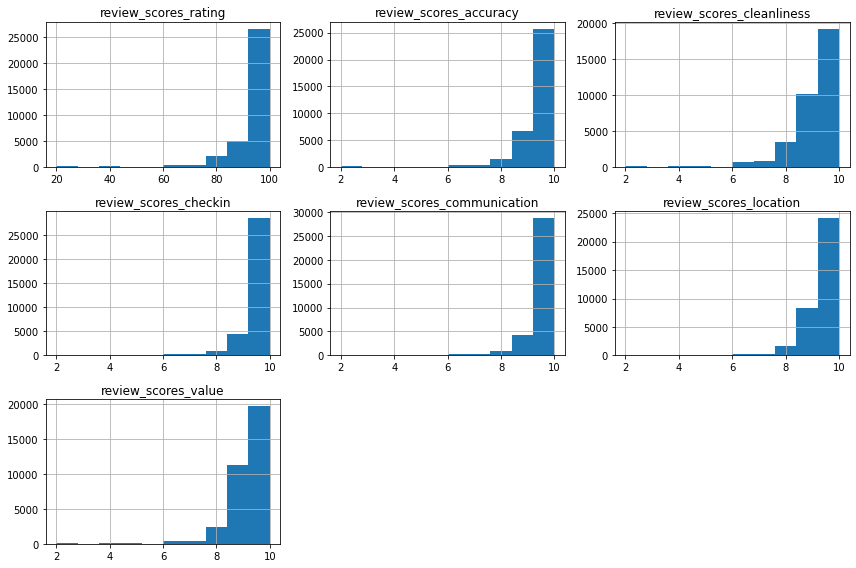

In [ ]:
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listings[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [ ]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [ ]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
   
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].fillna(na_label, inplace=True)
    

In [ ]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [ ]:
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [ ]:
listings.review_scores_rating.value_counts()

95-100/100    19857
80-94/100     12003
nan           11797
0-79/100       2835
Name: review_scores_rating, dtype: int64

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
listings.isna().sum()

id                                  0
description                         0
host_since                          0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_is_superhost                   0
host_total_listings_count           0
host_verifications                  0
host_has_profile_pic                0
host_identity_verified              0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                            0
beds                                0
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
availability_30                     0
number_of_reviews                   0
review_scores_rating                0
review_scores_accuracy              0
review_score

In [ ]:
listings.shape

(46492, 91)

**number_of_reviews_ltm and reviews_per_month**

These will be highly correlated with number_of_reviews and so will be dropped.

In [ ]:
listings.drop(['reviews_per_month'], axis=1, inplace=True)

In [ ]:
listings.isna().sum()

id                              0
description                     0
host_since                      0
host_response_time              0
host_response_rate              0
host_acceptance_rate            0
host_is_superhost               0
host_total_listings_count       0
host_verifications              0
host_has_profile_pic            0
host_identity_verified          0
neighbourhood_cleansed          0
neighbourhood_group_cleansed    0
property_type                   0
room_type                       0
accommodates                    0
bedrooms                        0
beds                            0
amenities                       0
price                           0
minimum_nights                  0
maximum_nights                  0
availability_60                 0
availability_90                 0
number_of_reviews               0
review_scores_rating            0
review_scores_accuracy          0
review_scores_cleanliness       0
review_scores_checkin           0
review_scores_

**This is where we combine the reviews table with the listing table and try to get the average polarity for each listings**

Lets rename column ID to listing_id to match
 with our listingid in our reviews table. This will allow us to merge easily using pandas merge


In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
listings = listings.rename(columns={"id":"listing_id"})

In [ ]:
listings.shape

(46492, 90)

In [ ]:
reviews_df.shape

(1059288, 6)

In [ ]:
reviews_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,2009-12-05,53267,Cate,Great experience.
2,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,2010-05-25,117113,Alicia,We had a wonderful stay at Jennifer's charming...
...,...,...,...,...,...,...
1059283,44655517,651018703,2020-08-14,259621095,Jwaun,This was a very nice & comfortable stay. The h...
1059284,44656261,650542605,2020-08-13,356791191,Roderick,"I loved my stay there it was quite, clean ever..."
1059285,44662157,649840303,2020-08-11,115206454,Amber,Great for budget & very easy check in!
1059286,44662157,650193899,2020-08-12,278549113,闹闹,"非常好的房源,干净整洁,睡眠质量超级好"


The number of rows is huge so I will try to do a groupy by listing ID

In [ ]:
grouped =reviews_df.groupby(['listing_id'])

In [ ]:
noReviews = listings[listings.number_of_reviews == 0]

I want to confirm the groupby was done properly

In [ ]:
len(listings)- len(noReviews)

35791

In [ ]:
len(reviews_df.listing_id.unique())

35816

put all the values for each listing in a tuple

In [ ]:
df = grouped.aggregate(lambda x: tuple(x))

In [ ]:
df.reset_index(level=0, inplace=True)

In [ ]:
df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,"(17857, 19176, 19760, 34320, 46312, 1238204, 1...","(2009-11-21, 2009-12-05, 2009-12-10, 2010-04-0...","(50679, 53267, 38960, 71130, 117113, 1783688, ...","(Jean, Cate, Anita, Kai-Uwe, Alicia, Sergey, L...",(Notre séjour de trois nuits.\r\nNous avons ap...
1,3831,"(20509269, 22232975, 22550887, 22984049, 23604...","(2014-09-30, 2014-11-02, 2014-11-09, 2014-11-1...","(20417598, 6050386, 15051380, 7279245, 1631085...","(Courtney, Monica, Lynette, Linnea, Benjamin, ...","(lisa is a wonderful, kind and thoughtful host..."
2,5121,"(3271, 5018, 15342, 17869, 20382, 21588, 25622...","(2009-05-28, 2009-07-04, 2009-10-27, 2009-11-2...","(2995, 23868, 39813, 52256, 62040, 53299, 6812...","(Misha, Yevgeniy, Gisela, Shri, Kristen, Dorin...","(Simple place, super nice guy., Great guy with..."
3,5136,"(9549695,)","(2014-01-02,)","(3585271,)","(Elise,)",(My family had a wonderful stay at Rebecca and...
4,5178,"(2091, 3015, 4019, 5138, 8211, 8365, 12867, 16...","(2009-05-06, 2009-05-23, 2009-06-14, 2009-07-0...","(8443, 15642, 19644, 18347, 32936, 29676, 3124...","(Dimitri, Duong, Jim, Enki, Tomas, Lukas, Mich...","(MR. Kasai was a grreat host , very helpful an..."
...,...,...,...,...,...,...
35811,44622787,"(649079896,)","(2020-08-09,)","(27207928,)","(Mark West,)","(I loved the apartment, the view was amazing f..."
35812,44633340,"(649466184,)","(2020-08-10,)","(316429593,)","(Ariani,)",(Great host! Easy to communicate! The place wa...
35813,44655517,"(651018703,)","(2020-08-14,)","(259621095,)","(Jwaun,)",(This was a very nice & comfortable stay. The ...
35814,44656261,"(650542605,)","(2020-08-13,)","(356791191,)","(Roderick,)","(I loved my stay there it was quite, clean eve..."


In [ ]:
listings

,listing_id,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,zipcode,bathroom_count,wifi,heat,essentials,kitchen,smoke_alarm,...,Dishes and silverware,Washer,Dryer,Fire extinguisher,Microwave,Cooking basics,Stove,Oven,Free street parking,First aid kit,Coffee maker,Elevator,Lock on bedroom door,Cable TV,Extra pillows and blankets,Private entrance,Long term stays allowed,Dishwasher,Luggage dropoff allowed,Host greets you,Gym,Paid parking off premises,Bathtub,Patio or balcony,Garden or backyard,Breakfast,Private living room,Free parking on premises,Ethernet connection,Room-darkening shades,Single level home,Indoor fireplace,Cleaning before checkout,Hot tub,BBQ grill,Building staff,Window guards,Paid parking on premises,Baking sheet,High chair
0,2595,"Beautiful, spacious skylit studio in the heart...",4359.0,within a day,50-89%,0-49%,0.0,6.0,9,1.0,1.0,Midtown,Manhattan,Apartment,Entire home/apt,2,1.0,1.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$175.00,3,1125,60,90,48,80-94/100,9/10,9/10,10/10,10/10,10/10,9/10,0,10018,1,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3831,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",4270.0,within a few hours,50-89%,90-99%,0.0,1.0,6,1.0,1.0,Clinton Hill,Brooklyn,Apartment,Entire home/apt,3,1.0,3.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$75.00,1,730,21,40,340,80-94/100,0-8/10,9/10,9/10,9/10,9/10,9/10,0,11238,1,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5121,<b>The space</b><br />HELLO EVERYONE AND THANK...,4212.0,unknown,unknown,50-89%,0.0,1.0,8,1.0,1.0,Bedford-Stuyvesant,Brooklyn,Apartment,Private room,2,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Heati...",$60.00,29,730,60,90,50,80-94/100,0-8/10,0-8/10,10/10,10/10,9/10,9/10,0,11216,1,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5136,We welcome you to stay in our lovely 2 br dupl...,4212.0,within a few hours,100%,unknown,0.0,1.0,3,1.0,0.0,Sunset Park,Brooklyn,Apartment,Entire home/apt,4,2.0,2.0,"[""Carbon monoxide alarm"", ""Dryer"", ""Cable TV"",...",$175.00,14,1125,12,20,1,95-100/100,10/10,10/10,10/10,10/10,0-8/10,10/10,0,11232,1.5,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5178,Please don’t expect the luxury here just a bas...,4184.0,within a few hours,100%,100%,0.0,1.0,4,1.0,0.0,Hell's Kitchen,Manhattan,Apartment,Private room,2,1.0,1.0,"[""Hangers"", ""Essentials"", ""Bed linens"", ""TV"", ...",$65.00,2,14,44,74,473,80-94/100,9/10,0-8/10,9/10,9/10,10/10,9/10,0,10019,1,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
merged = pd.merge(listings,df, how= 'outer', on='listing_id')

In [ ]:
listings.listing_id.unique()

array([    2595,     3831,     5121, ..., 44811717, 44814944, 44818009])

In [ ]:
merged

,listing_id,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,zipcode,bathroom_count,wifi,heat,essentials,kitchen,smoke_alarm,...,Cooking basics,Stove,Oven,Free street parking,First aid kit,Coffee maker,Elevator,Lock on bedroom door,Cable TV,Extra pillows and blankets,Private entrance,Long term stays allowed,Dishwasher,Luggage dropoff allowed,Host greets you,Gym,Paid parking off premises,Bathtub,Patio or balcony,Garden or backyard,Breakfast,Private living room,Free parking on premises,Ethernet connection,Room-darkening shades,Single level home,Indoor fireplace,Cleaning before checkout,Hot tub,BBQ grill,Building staff,Window guards,Paid parking on premises,Baking sheet,High chair,id,date,reviewer_id,reviewer_name,comments
0,2595,"Beautiful, spacious skylit studio in the heart...",4359.0,within a day,50-89%,0-49%,0.0,6.0,9.0,1.0,1.0,Midtown,Manhattan,Apartment,Entire home/apt,2.0,1.0,1.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$175.00,3.0,1125.0,60.0,90.0,48.0,80-94/100,9/10,9/10,10/10,10/10,10/10,9/10,0.0,10018,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(17857, 19176, 19760, 34320, 46312, 1238204, 1...","(2009-11-21, 2009-12-05, 2009-12-10, 2010-04-0...","(50679, 53267, 38960, 71130, 117113, 1783688, ...","(Jean, Cate, Anita, Kai-Uwe, Alicia, Sergey, L...",(Notre séjour de trois nuits.\r\nNous avons ap...
1,3831,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",4270.0,within a few hours,50-89%,90-99%,0.0,1.0,6.0,1.0,1.0,Clinton Hill,Brooklyn,Apartment,Entire home/apt,3.0,1.0,3.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$75.00,1.0,730.0,21.0,40.0,340.0,80-94/100,0-8/10,9/10,9/10,9/10,9/10,9/10,0.0,11238,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(20509269, 22232975, 22550887, 22984049, 23604...","(2014-09-30, 2014-11-02, 2014-11-09, 2014-11-1...","(20417598, 6050386, 15051380, 7279245, 1631085...","(Courtney, Monica, Lynette, Linnea, Benjamin, ...","(lisa is a wonderful, kind and thoughtful host..."
2,5121,<b>The space</b><br />HELLO EVERYONE AND THANK...,4212.0,unknown,unknown,50-89%,0.0,1.0,8.0,1.0,1.0,Bedford-Stuyvesant,Brooklyn,Apartment,Private room,2.0,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Heati...",$60.00,29.0,730.0,60.0,90.0,50.0,80-94/100,0-8/10,0-8/10,10/10,10/10,9/10,9/10,0.0,11216,1,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(3271, 5018, 15342, 17869, 20382, 21588, 25622...","(2009-05-28, 2009-07-04, 2009-10-27, 2009-11-2...","(2995, 23868, 39813, 52256, 62040, 53299, 6812...","(Misha, Yevgeniy, Gisela, Shri, Kristen, Dorin...","(Simple place, super nice guy., Great guy with..."
3,5136,We welcome you to stay in our lovely 2 br dupl...,4212.0,within a few hours,100%,unknown,0.0,1.0,3.0,1.0,0.0,Sunset Park,Brooklyn,Apartment,Entire home/apt,4.0,2.0,2.0,"[""Carbon monoxide alarm"", ""Dryer"", ""Cable TV"",...",$175.00,14.0,1125.0,12.0,20.0,1.0,95-100/100,10/10,10/10,10/10,10/10,0-8/10,10/10,0.0,11232,1.5,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(9549695,)","(2014-01-02,)

WE removed some listings that had some reviews so I will just check how many and if its low I will just remove those 

In [ ]:
naRows = merged[merged.host_since.isna()]

In [ ]:
len(naRows)

25

In [ ]:
merged.drop(merged.tail(len(naRows)).index,inplace= True)

In [ ]:
merged

,listing_id,description,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_60,availability_90,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,zipcode,bathroom_count,wifi,heat,essentials,kitchen,smoke_alarm,...,Cooking basics,Stove,Oven,Free street parking,First aid kit,Coffee maker,Elevator,Lock on bedroom door,Cable TV,Extra pillows and blankets,Private entrance,Long term stays allowed,Dishwasher,Luggage dropoff allowed,Host greets you,Gym,Paid parking off premises,Bathtub,Patio or balcony,Garden or backyard,Breakfast,Private living room,Free parking on premises,Ethernet connection,Room-darkening shades,Single level home,Indoor fireplace,Cleaning before checkout,Hot tub,BBQ grill,Building staff,Window guards,Paid parking on premises,Baking sheet,High chair,id,date,reviewer_id,reviewer_name,comments
0,2595,"Beautiful, spacious skylit studio in the heart...",4359.0,within a day,50-89%,0-49%,0.0,6.0,9.0,1.0,1.0,Midtown,Manhattan,Apartment,Entire home/apt,2.0,1.0,1.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$175.00,3.0,1125.0,60.0,90.0,48.0,80-94/100,9/10,9/10,10/10,10/10,10/10,9/10,0.0,10018,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(17857, 19176, 19760, 34320, 46312, 1238204, 1...","(2009-11-21, 2009-12-05, 2009-12-10, 2010-04-0...","(50679, 53267, 38960, 71130, 117113, 1783688, ...","(Jean, Cate, Anita, Kai-Uwe, Alicia, Sergey, L...",(Notre séjour de trois nuits.\r\nNous avons ap...
1,3831,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",4270.0,within a few hours,50-89%,90-99%,0.0,1.0,6.0,1.0,1.0,Clinton Hill,Brooklyn,Apartment,Entire home/apt,3.0,1.0,3.0,"[""Coffee maker"", ""Refrigerator"", ""Heating"", ""I...",$75.00,1.0,730.0,21.0,40.0,340.0,80-94/100,0-8/10,9/10,9/10,9/10,9/10,9/10,0.0,11238,1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(20509269, 22232975, 22550887, 22984049, 23604...","(2014-09-30, 2014-11-02, 2014-11-09, 2014-11-1...","(20417598, 6050386, 15051380, 7279245, 1631085...","(Courtney, Monica, Lynette, Linnea, Benjamin, ...","(lisa is a wonderful, kind and thoughtful host..."
2,5121,<b>The space</b><br />HELLO EVERYONE AND THANK...,4212.0,unknown,unknown,50-89%,0.0,1.0,8.0,1.0,1.0,Bedford-Stuyvesant,Brooklyn,Apartment,Private room,2.0,1.0,1.0,"[""Kitchen"", ""Wifi"", ""Air conditioning"", ""Heati...",$60.00,29.0,730.0,60.0,90.0,50.0,80-94/100,0-8/10,0-8/10,10/10,10/10,9/10,9/10,0.0,11216,1,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(3271, 5018, 15342, 17869, 20382, 21588, 25622...","(2009-05-28, 2009-07-04, 2009-10-27, 2009-11-2...","(2995, 23868, 39813, 52256, 62040, 53299, 6812...","(Misha, Yevgeniy, Gisela, Shri, Kristen, Dorin...","(Simple place, super nice guy., Great guy with..."
3,5136,We welcome you to stay in our lovely 2 br dupl...,4212.0,within a few hours,100%,unknown,0.0,1.0,3.0,1.0,0.0,Sunset Park,Brooklyn,Apartment,Entire home/apt,4.0,2.0,2.0,"[""Carbon monoxide alarm"", ""Dryer"", ""Cable TV"",...",$175.00,14.0,1125.0,12.0,20.0,1.0,95-100/100,10/10,10/10,10/10,10/10,0-8/10,10/10,0.0,11232,1.5,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(9549695,)","(2014-01-02,)

**The Fun Part**

So now that we successfully merged the listings and erviews table. I will attempt to get the average polarity score of each listings.I am looking at polarity since that is quantive number([-1,1]) where closer to one means a postive sentence and closer to -1 means a negative evaluation. I do this using a api called TextBlob which simplies the process of doing semantic analysis

There are apporximately 10k values missing. My plan is to fill those reviews with 0 since a polarity of 0 means a neutral view. A listing with no reviews cannot be neither postive or negative os neutral would be a good fit.

In [ ]:
merged['comments'].isna().sum()

10701

In [ ]:
merged.comments.fillna('0',inplace=True)

There are some reviews that are written in a different language. The TExtBlob api used to do semantic analysis doesn't work for other languages. SO I will using a api to detect if the language is english and if its then I will get its score 

In [ ]:
merged.comments[0][0]

'Notre séjour de trois nuits.\r\nNous avons apprécier L\'appartement qui est très bien situé. Agréable, propre et bien soigné. C\'est idéal pour une famille de 3 ou 4 personnes.\r\nPetits soucis en arrivant il y avait personne pour nous recevoir, et il manquait le savon pour la douche, le liquide vaisselle, nous les avons reçu de surlendemain. Il y a aussi le bruit du Métro de NY, donc une première nuit difficile si on est pas habitué. Jennifer est correcte le remboursement de la caution était très rapide.  A part ces petits détails notre court séjour c\'est bien passé. \r\nSi j\'ai la possibilité de revenir sur NY pour les vacances, je reprendrai à "The Midtown Castle"\r\nJean\r\nPossession - Ile de La Réunion\r\n'

In [ ]:
merged.comments[0][1]

'Great experience.'

This messy code gets the reviews for each listings , then checks if its english first. IF it is english then we shall get its polarty score and put it in the list. Once we get all the reviews polarity score we shall get the average and put it into another list. We keep repeating and doing this for all 45k listings :) (takes about 1-2 hours)

In [ ]:
score = [] # this will store the average a=polarity score for each listings
k = 0
for ind in merged.index:
  avg = [] # this will store each reviews polarity score for ind index so its a temporary list 
  for i in merged.comments[ind]:
    #print(i)
    #k = k + 1
    #print(k)
    try:
      #print('test')
      if i == '0': # if 0 it means this was a listings with no reviews so dont bother processing further
        avg.append(0)
      elif detect(i) == 'en': # here we check if its english then get its polarity score 
        #print('eng')
        blob = TextBlob(i)
        avg.append(blob.sentiment.polarity)
        print(blob.sentiment.polarity)
        #print('avg',len(avg))
    except: # unfortunately there is some data that is just some randome characters or emotes 
      print('text causing error',i)
  if(len(avg) > 0): # to prevent the loop crashing when the avg list is empty because of invalid characters 
    score.append(sum(avg) / len(avg))
  else: # add 0 for invalid characters.
    score.append(0)

Streaming output truncated to the last 5000 lines.
0.8
0.55
0.3738095238095238
0.3425
0.5833333333333333
0.396031746031746
0.875
0.43333333333333335
0.5
0.11407407407407409
0.39814814814814814
0.0
0.5922222222222222
0.8
0.25833333333333336
0.4
0.2738888888888889
0.5710000000000001
0.9
0.2572916666666667
0.15609567901234567
0.36095238095238097
0.875
0.5
0.8
0.06666666666666667
0.3666666666666667
0.0
0.3166666666666667
0.0
0.5893333333333334
0.0
0.1907407407407407
0.5
0.2141041912632822
0.4496428571428572
0.28687969924812035
0.4158823529411765
0.3140625
0.295
0.47696969696969693
0.33854166666666663
0.3084129033844943
0.4789880952380953
0.4208333333333334
0.43166666666666664
0.4788888888888889
0.5035714285714286
0.3824074074074074
0.415530303030303
0.42500000000000004
0.34493939393939393
0.4333333333333333
0.47388888888888897
0.3785714285714286
0.7166666666666667
0.6714285714285714
0.4033333333333333
0.06875000000000003
0.39166666666666666
-0.11666666666666664
0.43500000000000005
0.320833

In [ ]:
len(score)# check the length to make sure all is good 

46492

In [ ]:
listings['polarity'] = score # assign score as column callled polarity 

In [ ]:
t = listings[listings.number_of_reviews == 0]

In [ ]:
t.polarity.value_counts()

0.0    10701
Name: polarity, dtype: int64

In [ ]:
len(listings)  # make sure once again everything adds up

46492

Save this file so I dont have wait 1-2 hours again :)

In [ ]:
listings.to_csv('listingsPolarity.csv')
files.download('listingsPolarity.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
listings['price'] = listings['price'].str.replace(',', '').str.replace('$', '').astype(float)


In [ ]:
listings.polarity.value_counts()

0.000000    12364
1.000000      112
0.800000       97
0.500000       90
0.600000       57
            ...  
0.461574        1
0.402900        1
0.481044        1
0.457660        1
0.402997        1
Name: polarity, Length: 31718, dtype: int64

In [ ]:
listings.polarity.value_counts()

0.5      27146
-0.25    12506
0.75      4051
.25       2322
1          420
-0.50       27
-1          11
-0.75        9
Name: polarity, dtype: int64

In [ ]:
merged['polarity'] = score

In [ ]:
merged.polarity.value_counts()

0.000000    12364
1.000000      112
0.800000       97
0.500000       90
0.600000       57
            ...  
0.461574        1
0.402900        1
0.481044        1
0.457660        1
0.402997        1
Name: polarity, Length: 31718, dtype: int64

In [ ]:
def bin_col(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    merged[col] = pd.cut(merged[col], bins=bins, labels=labels, include_lowest=True)
    merged[col] = merged[col].astype('str')
    merged[col].fillna(na_label, inplace=True)

In [ ]:
bin_col('polarity',bins=[-1,-0.75,-0.50,-0.25,0,0.25,0.5,0.75,1],labels=['-1/0.75','-0.75/0.50','-0.50/0.25','0','.25-0.5','0.5/.75','0.75/1','1'],na_label='no reviews')

In [ ]:
merged['polarity'].value_counts()

0.5/.75       27146
0             12506
0.75/1         4051
.25-0.5        2322
1               420
-0.50/0.25       27
-1/0.75          11
-0.75/0.50        9
Name: polarity, dtype: int64

In [ ]:
listings.value_counts()

listing_id  description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 